## Comparing over-sampling methods using cross-validation and hyperparameter tuning

[Machine Learning with Imbalanced Data - Course](https://www.trainindata.com/p/machine-learning-with-imbalanced-data)

When we train a classifier, we want it to predict an outcome in a real life dataset. Thus, it is important to evaluate the performance of the classifier on a data set with the original distribution of classes, and not on the rebalanced data.

This means, that the over-sampling methods should be performed on the dataset that we are going to use to train the classifier. But, **the performance of the model should be determined on a portion of the data, that was not re-sampled**.

In this notebook, we will use the imbalanced-learn pipeline, to set up various over-sampling solutions in a way that we train the model on re-sampled data, but we evaluate performance on non-resampled data.

In addition, we will optimize the hyperparamters of the random forests, so we ensure we have the best possible model, trained on each dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.datasets import fetch_datasets

from imblearn.ensemble import (
    BalancedRandomForestClassifier,
    RUSBoostClassifier,
    EasyEnsembleClassifier,
)

In [2]:
datasets_ls = [
    'ecoli',
    'optical_digits',
    'satimage',
    'pen_digits',
    'abalone',
    'sick_euthyroid',
    'spectrometer',
    'car_eval_34',
    'isolet',
    'us_crime',
    'yeast_ml8',
    'scene',
    'libras_move',
    'thyroid_sick',
    'coil_2000',
    'arrhythmia',
    'solar_flare_m0',
    'oil',
    'car_eval_4',
    'wine_quality',
    'letter_img',
    'yeast_me2',
    'webpage',
    'ozone_level',
    'mammography',
    'protein_homo',
    'abalone_19',
]

len(datasets_ls)

27

In [3]:
# ensemble methods (with or without resampling)

ensemble_dict = {
    
    # just bagging
    'random_forests': RandomForestClassifier(random_state=39),     
    
    # just boosting
    'adaboost' : AdaBoostClassifier(
        algorithm="SAMME",
        random_state=2909,
    ),
    
    # stronger boosting algo
    'gbm' : GradientBoostingClassifier(random_state=39),

    # balanced random forests (balanced bagging)
    'balancedRF': BalancedRandomForestClassifier(
        criterion='gini',
        sampling_strategy='auto',
        random_state=2909,
        replacement=False,
        bootstrap=True,
    ),

    # bagging of adaboost, no resampling
    'bagging': BaggingClassifier(
        # estimator=ada, we'll optimize this parameter
        n_estimators=20,
        n_jobs=4,
        random_state=2909,
    ),

    # boosting + undersampling
    'rusboost': RUSBoostClassifier(
        estimator=None,
        n_estimators=20,
        learning_rate=1.0,
        sampling_strategy='auto',
        random_state=2909,
    ),

    # bagging + boosting + under-sammpling
    'easyEnsemble': EasyEnsembleClassifier(
        n_estimators=20,
        sampling_strategy='auto',
        n_jobs=4,
        random_state=2909,
    ),
}

In [4]:
# adaboost with different tree sizes for bagging
# without resampling

ada_ls = [
    AdaBoostClassifier(
        n_estimators=5,
        algorithm="SAMME",
        random_state=2909,
    ),
    
    AdaBoostClassifier(
        n_estimators=10,
        algorithm="SAMME",
        random_state=2909,
    ),
    
    AdaBoostClassifier(
        n_estimators=20,
        algorithm="SAMME",
        random_state=2909,
    ),
    

    AdaBoostClassifier(
        n_estimators=40,
        algorithm="SAMME",
        random_state=2909,
    ),   
]

In [5]:
nestimators_params = {"n_estimators": [5, 10, 20, 40]}

nestimators_depth_params = {
    "n_estimators": [10, 50, 100, 500],
    "max_depth": [1, 2, 3, 4],
}

bagged_ada_params = {
    "n_estimators": [10, 50, 100, 500],
    "estimator": ada_ls,
}


In [7]:
# now we train several models, with the different ensembles and
# with cross-validation for each dataset

# to store the results
mean_dict = {}
std_dict = {}
model_dict = {}


for dataset in datasets_ls:

    # initiate a dictionary per dataset
    mean_dict[dataset] = {}
    std_dict[dataset] = {}
    model_dict[dataset] = {}

    print(dataset)

    # load dataset
    data = fetch_datasets()[dataset]

    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        data.data,
        data.target,
        test_size=0.3,
        random_state=0,
    )

    for ensemble in ensemble_dict.keys():
        
        print(ensemble)
        
        model = ensemble_dict[ensemble]
        
        if ensemble in ["random_forests", "gbm"]:
            params = nestimators_depth_params
        elif ensemble in ["bagging"]:
            params = bagged_ada_params
        else:
            params = nestimators_params

        # train and evaluate performance
        # with cross-validation
        search = GridSearchCV(
            model,
            params,
            scoring="roc_auc",
        )

        search.fit(X_train, y_train)

        print('Best parameters: {0}, \n Best score: {1}'.format(
            search.best_params_, search.best_score_))

        m, s = pd.DataFrame(search.cv_results_).sort_values(
            by="mean_test_score",
            ascending=False).loc[0, ["mean_test_score", "std_test_score"]].values

        # store results
        mean_dict[dataset][ensemble] = m
        std_dict[dataset][ensemble] = s
        model_dict[dataset][ensemble] = search
        
        print()

    print()

ecoli
random_forests
Best parameters: {'max_depth': 4, 'n_estimators': 10}, 
 Best score: 0.9289314750290361

adaboost
Best parameters: {'n_estimators': 10}, 
 Best score: 0.9057026713124273

gbm
Best parameters: {'max_depth': 3, 'n_estimators': 100}, 
 Best score: 0.9251916376306621

balancedRF
Best parameters: {'n_estimators': 40}, 
 Best score: 0.9197909407665505

bagging
Best parameters: {'estimator': AdaBoostClassifier(algorithm='SAMME', n_estimators=20, random_state=2909), 'n_estimators': 500}, 
 Best score: 0.919465737514518

rusboost
Best parameters: {'n_estimators': 40}, 
 Best score: 0.9021835075493613

easyEnsemble
Best parameters: {'n_estimators': 40}, 
 Best score: 0.9300580720092915


optical_digits
random_forests
Best parameters: {'max_depth': 4, 'n_estimators': 500}, 
 Best score: 0.9830423101721566

adaboost
Best parameters: {'n_estimators': 40}, 
 Best score: 0.9801000713211525

gbm
Best parameters: {'max_depth': 4, 'n_estimators': 500}, 
 Best score: 0.99940419927261

Best parameters: {'estimator': AdaBoostClassifier(algorithm='SAMME', n_estimators=40, random_state=2909), 'n_estimators': 50}, 
 Best score: 0.7883436972885879

rusboost
Best parameters: {'n_estimators': 5}, 
 Best score: 0.7037020719518643

easyEnsemble
Best parameters: {'n_estimators': 40}, 
 Best score: 0.7884846806475165


libras_move
random_forests
Best parameters: {'max_depth': 4, 'n_estimators': 500}, 
 Best score: 0.9334219858156029

adaboost
Best parameters: {'n_estimators': 20}, 
 Best score: 0.8997931442080379

gbm
Best parameters: {'max_depth': 2, 'n_estimators': 500}, 
 Best score: 0.9182624113475178

balancedRF
Best parameters: {'n_estimators': 40}, 
 Best score: 0.9059692671394799

bagging
Best parameters: {'estimator': AdaBoostClassifier(algorithm='SAMME', n_estimators=20, random_state=2909), 'n_estimators': 10}, 
 Best score: 0.9130614657210401

rusboost
Best parameters: {'n_estimators': 40}, 
 Best score: 0.8148640661938534

easyEnsemble
Best parameters: {'n_estimator

Best parameters: {'n_estimators': 40}, 
 Best score: 0.8732097772466831

gbm
Best parameters: {'max_depth': 2, 'n_estimators': 100}, 
 Best score: 0.892322456108098

balancedRF
Best parameters: {'n_estimators': 40}, 
 Best score: 0.8870759260961487

bagging
Best parameters: {'estimator': AdaBoostClassifier(algorithm='SAMME', n_estimators=40, random_state=2909), 'n_estimators': 500}, 
 Best score: 0.8987448907681465

rusboost
Best parameters: {'n_estimators': 40}, 
 Best score: 0.8619624965529921

easyEnsemble
Best parameters: {'n_estimators': 40}, 
 Best score: 0.8989836382020406


mammography
random_forests
Best parameters: {'max_depth': 4, 'n_estimators': 50}, 
 Best score: 0.938652370486903

adaboost
Best parameters: {'n_estimators': 40}, 
 Best score: 0.9210240161679011

gbm
Best parameters: {'max_depth': 3, 'n_estimators': 100}, 
 Best score: 0.9311819340596319

balancedRF
Best parameters: {'n_estimators': 20}, 
 Best score: 0.9323928081122326

bagging
Best parameters: {'estimator

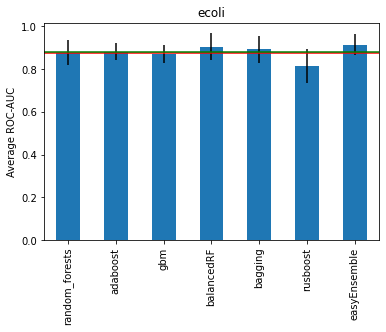

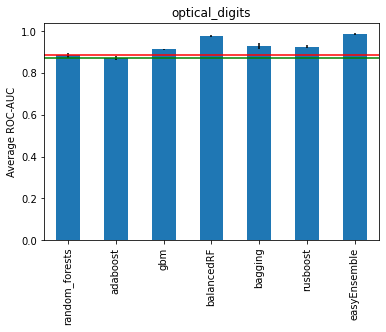

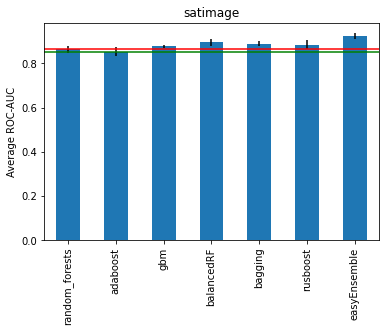

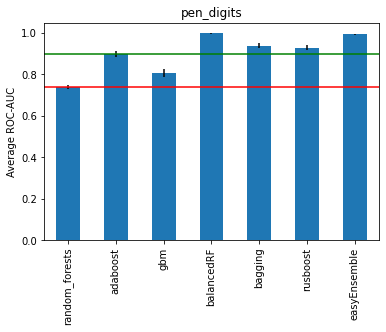

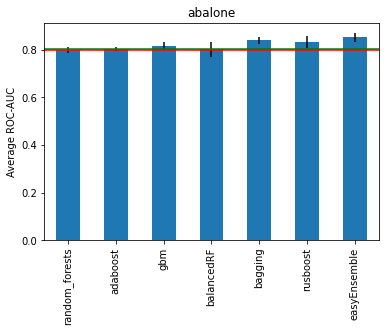

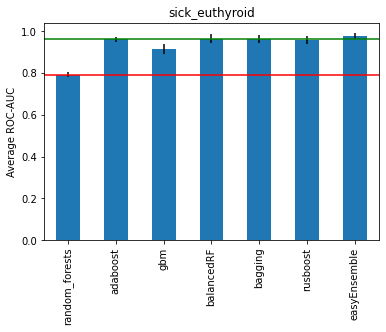

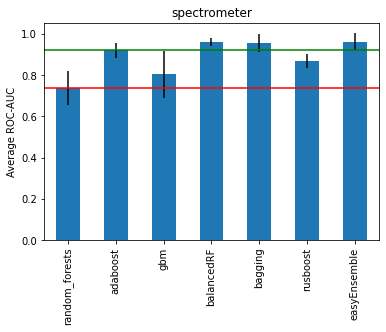

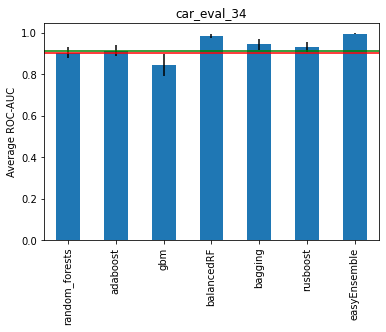

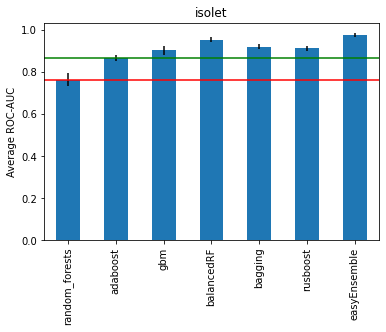

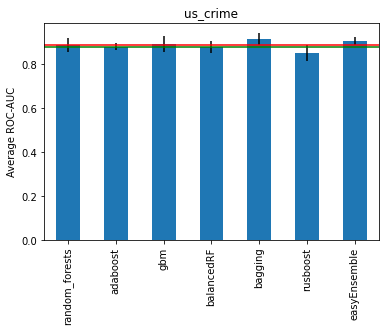

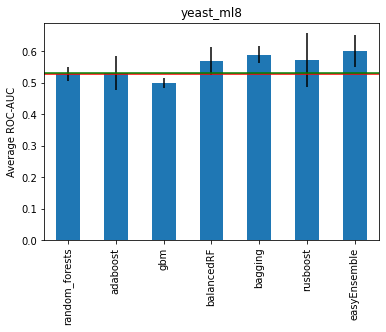

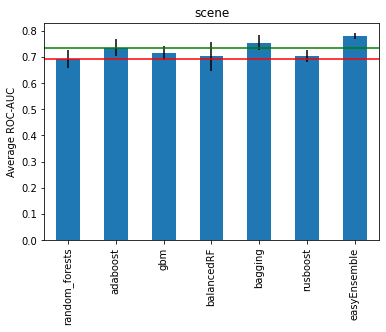

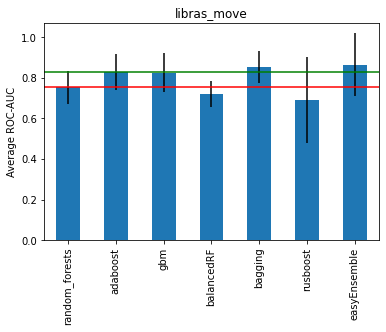

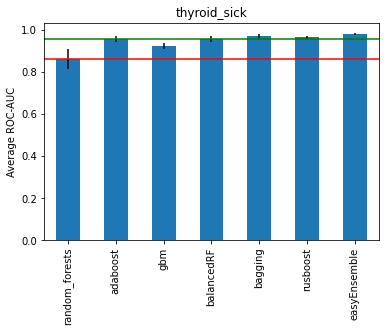

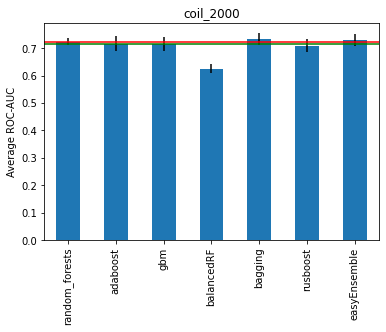

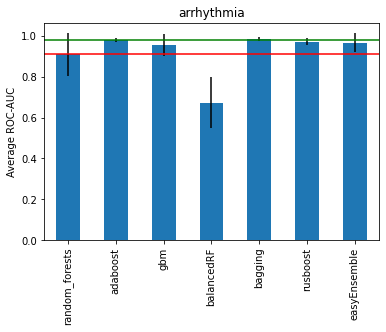

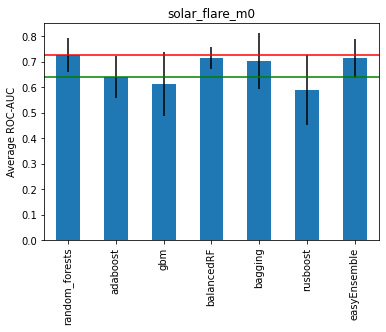

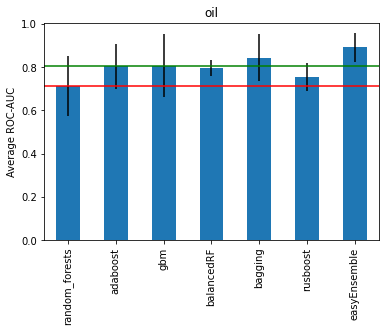

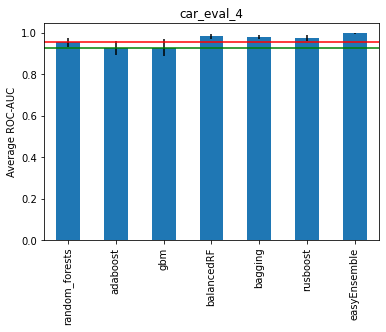

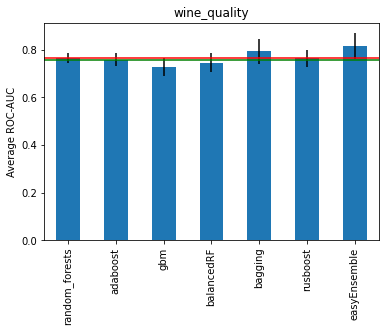

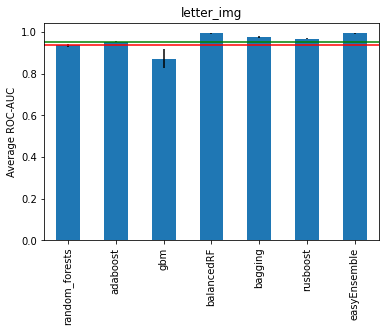

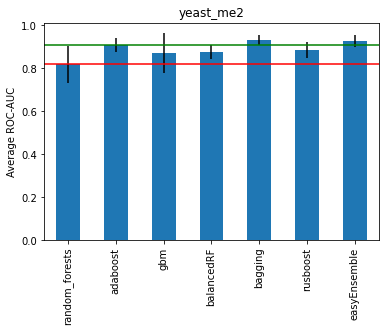

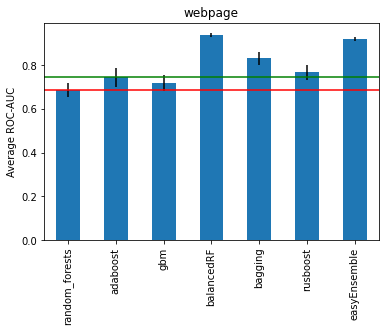

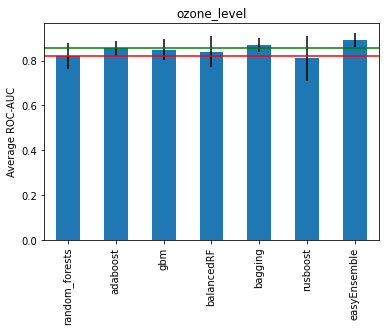

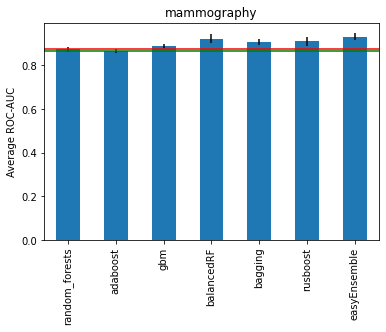

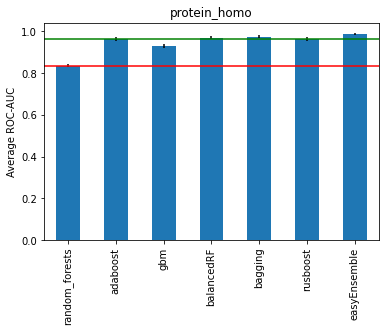

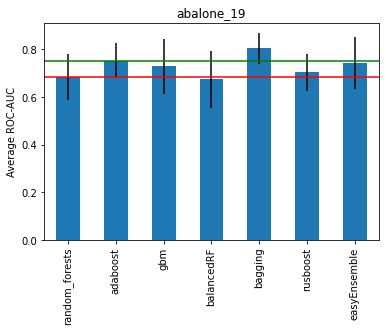

In [11]:
# Now we plot the performance of the models

for dataset in datasets_ls:
    
    mean_s = pd.Series(mean_dict[dataset])
    std_s = pd.Series(std_dict[dataset])
    
    mean_s.plot.bar(yerr=[std_s, std_s]
        )
    plt.title(dataset)
    plt.ylabel('Average ROC-AUC')
    plt.axhline(mean_dict[dataset]['random_forests'], color='r')
    plt.axhline(mean_dict[dataset]['adaboost'], color='g')
    plt.show()

As you can see from the plots, ensemble methods tend to return better results for most datasets. Based on these tests, they are worth a try. These is what we see with more granularity:

- In 7 datasets, adaboost clearly outperformed random forests, but random forests never outperformed adaboost.

We expected that because boosting is, in general, a better model than just bagging.

- Sklearn's implementation of gbm outperformed random forests only in 4 datasets. 

I find this a bit unusual, because gbms are better than adaboost in general, so I expected at least, the same success as adaboost. Maybe the hyperparameter space that we searched was not optimal. It might be worth comparing the results with those of xgboost. I leave this with you.

- Balanced random forests and easyEnsemble outperformed adaboost in 8 and 10 datasets, respectively.

These 2 models are quite promising, and the good news is, that they are relatively fast to train.

- Bagging of adaboost and rusBoost showed good performance overall, but it is less clear if their performance is significantly superior to that of adaboost.

And those models are quite costly, so, unless we have access to good computing resources, we can stick to balanced random forests and easyEnsemble.

In [12]:
import pickle 

with open('ensemble_mean.pkl', 'wb') as f:
    pickle.dump(mean_dict, f)

with open('ensemble_std.pkl', 'wb') as f:
    pickle.dump(std_dict, f)
    
with open('esemble_model.pkl', 'wb') as f:
    pickle.dump(model_dict, f)